In [1]:
%load_ext autoreload
%autoreload 2
import torch
from torch.utils.data import Dataset
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tqdm

# Toy Example

We want to verify that the cdf loss helps in scenarios with limited data and label noise

In [29]:
# Data
class SimpleNoiseRegData(Dataset):
    def __init__(self, N, noise_scale = 0.2, relative_percentage = 0.0):
        super().__init__()
        d_dim = 1
        #self.weight = torch.Tensor([[1.7, 0]])
        self.weight = torch.Tensor([[1.7]])
        self.bias = torch.Tensor([-0.5])
            
        # We first construct a very simple nonlinear regression problem, mapping from 5 dimensions to 1
        self.N = N
        #self.data = torch.randn((N,d_dim))
        self.data = torch.rand((N,d_dim))*8-5
        #self.clean_labels = (torch.einsum("ij, Bj -> Bi", self.weight, self.data) + self.bias)**2
        self.clean_labels = torch.einsum("ij, Bj -> Bi", self.weight, self.data) + self.bias + 2*torch.sin(2*torch.einsum("ij, Bj -> Bi", self.weight, self.data))
        
        
        if noise_scale < 0:
            data_dependend_noise = torch.nn.functional.softplus(self.data[:,-1:])*0.1
            self.labels = self.clean_labels + torch.normal(torch.zeros(self.clean_labels.shape), data_dependend_noise)
        else:
            self.labels = self.clean_labels + torch.normal(torch.zeros(self.clean_labels.shape), noise_scale)
        self.N_full_data = int(self.N * (1-relative_percentage))
            
    def normalize(self, mean=None, std=None):
        if mean is None:
            mean = torch.mean(self.labels)
        if std is None:
            std = torch.std(self.labels)
        self.clean_labels = (self.clean_labels - mean) / std
        self.labels = (self.labels - mean) / std
        self.mean = mean
        self.std = std
        return mean, std
        
    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        if idx < self.N_full_data:
            matching_idx = np.random.randint(self.N_full_data)
            return self.data[idx], self.labels[idx], self.data[matching_idx], self.labels[matching_idx], 1
        else:
            matching_idx = np.random.randint(self.N_full_data,self.N)
            return self.data[idx], self.labels[idx] - self.labels[matching_idx], self.data[matching_idx], self.labels[matching_idx]- self.labels[idx], 0
    
def get_data_loader(noise_scale=0, n_samples = 100, normalization = None, relative_percentage=0.0 ):
    dataset = SimpleNoiseRegData(n_samples, noise_scale=noise_scale, relative_percentage=relative_percentage)
    val_dataset = SimpleNoiseRegData(1000, noise_scale=noise_scale)
    
    if normalization is None:
        mean, std = dataset.normalize()
        val_dataset.normalize(mean, std)
    elif isinstance(normalization, tuple):
        mean, std = normalization
        dataset.normalize(mean, std)
        val_dataset.normalize(mean, std)
    train_loader = torch.utils.data.DataLoader(dataset,batch_size=batch_size,shuffle=True) 
    val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size,shuffle=False)
    return train_loader, val_loader


In [30]:
# Models
class SimpleModel(torch.nn.Module):
    def __init__(self, n_in, n_out, n_hidden):
        super().__init__()
        self.in_layer = torch.nn.Linear(n_in, n_hidden)
            
        self.layer = torch.nn.Sequential(
            torch.nn.SELU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.SELU(),
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.SELU(),
            torch.nn.Linear(n_hidden, n_out)
        )
    def forward(self, x):
        y =  self.layer(self.in_layer(x))
        return torch.concatenate((y[:,:-1],torch.nn.functional.softplus(y[:,-1:])),dim=1)

class MatchingModel(torch.nn.Module):
    def __init__(self, n_in, n_out,bias=True):
        super().__init__()
        self.in_layer = torch.nn.Linear(n_in, n_out,bias=bias)
    def forward(self, x):
        #return self.in_layer(x) **2
        y = self.in_layer(x)
        return torch.stack((y[:,0] **2,torch.nn.functional.softplus(y[:,1])),dim=1)
    
def relative_loss(x1, x2, label, rel_temperature=0.2, mask=None):
    
    diff_1 = x1 - x2
    diff_2 = x2 - x1

    log_prob_1_ge_2 = torch.special.log_ndtr(diff_1.flatten() / 2 ** 0.5 / rel_temperature)
    log_prob_2_ge_1 = torch.special.log_ndtr(diff_2.flatten() / 2 ** 0.5 / rel_temperature)
    combined =  torch.stack((log_prob_1_ge_2, log_prob_2_ge_1), dim=-1)
    return torch.nn.functional.nll_loss(combined, label, reduction="mean")
    
def mse_loss(x1, label, mask=None):
    if mask is not None and torch.sum(mask)>0:
        
        return torch.sum(mask * torch.nn.functional.mse_loss(x1, label, reduction="none")) / torch.sum(mask)
    elif mask is not None:
        # We have no absolute information in this batch
        return torch.zeros_like(x1).mean()
    return torch.nn.functional.mse_loss(x1, label)

def nll_loss(output, label, scale, mask=None):
    if mask is not None and torch.sum(mask)>0:
        return torch.sum(mask*(torch.log(torch.clamp(scale,1e-6)) + (output - label)**2 / (torch.clamp(2*scale**2,1e-6))))/ torch.sum(mask)
    elif mask is not None:
        # We have no absolute information in this batch
        return torch.zeros_like(output).mean()
    
    return torch.mean((torch.log(torch.clamp(scale,1e-6)) + (output - label)**2 / (torch.clamp(2*scale**2,1e-6))))
    #return torch.sum(0.5 * (torch.log(2*torch.clamp(var,1e-6)**2) + (output - label)**2 / (2*torch.clamp(var,1e-6)**2)))

cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)
def cosine_sim(output, label, mask=None):
    if mask is not None and torch.sum(mask)>0:
        mask = mask.nonzero()[:,0]
        output = output[mask]
        label = label[mask]
        return -1*cos(output, label).sum()
    elif mask is not None:
        # We have no absolute information in this batch
        return torch.zeros_like(output).mean()
    else:
        return -1*cos(output, label).sum()
    
def pearson_corr(output, label, mask=None):
    if mask is not None and torch.sum(mask)>1:
        mask = mask.nonzero()[:,0]
        output = output[mask]
        label = label[mask]
        return -1* cos(output - output.mean(dim=0, keepdim=True), label - label.mean(dim=0, keepdim=True)).sum()
    elif mask is not None:
        # We have no absolute information in this batch
        return torch.zeros_like(output).mean()
    else:
        return -1* cos(output - output.mean(dim=0, keepdim=True), label - label.mean(dim=0, keepdim=True)).sum() 

In [46]:
def init_model(seed=42, weight_init=None):
    torch.random.manual_seed(seed)
    np.random.seed(seed)
    model = SimpleModel(1,2,64)
    #model = SimpleModel(1,2,32)
    #model = MatchingModel(2,2)
    if torch.cuda.is_available():
            model = model.to("cuda")
    #optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Define a learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=10, factor=0.5, verbose=False)
    return model, optimizer, scheduler


In [41]:
   
def train(model_name,train_loader,val_dataset, seed=42,weight_init=None):
    val_losses = {}
    model, optimizer, scheduler = init_model(seed=seed, weight_init=weight_init)
    with tqdm.tqdm(range(epochs), unit="epoch") as tepoch:
        #model_name = "relative"
        val_losses[f"{model_name}_pearson"]=[]
        val_losses[f"{model_name}_mse"]=[]
        for epoch in tepoch:
            total_loss = 0
            for (x, y, x2, y2, absolute_data) in train_loader:
                if torch.cuda.is_available():
                    x = x.to("cuda")
                    y = y.to("cuda")    
                    x2 = x2.to("cuda")
                    y2 = y2.to("cuda")  
                    absolute_data = absolute_data.to("cuda")
                optimizer.zero_grad()
            
                out = model(x)
                out2 = model(x2)
            
                #uncertainty = (torch.nn.functional.softplus(out[:,1]) + torch.nn.functional.softplus(out2[:,1]))/2
                if "relative" in model_name:
                    if "detach" in model_name:
                        uncertainty = (out[:,-1:] +out2[:,-1:].detach())/2
                    else:
                        uncertainty = (out[:,-1:] +out2[:,-1:])/2
                else:
                    uncertainty = out[:,-1:]
                # get loss for the predicted output
                loss = 0
                if "relative_fixed" in model_name:
                    loss = loss + relative_loss(out[:,0], out2[:,0], (y2 > y)[:,0].long(), rel_temperature=0.2)
                if "relative_true" in model_name:
                    loss = relative_loss(out[:,0], out2[:,0], (y2 > y)[:,0].long(), rel_temperature=noise_scale if noise_scale >0 else 0.2)
                elif "relative_detach" in model_name:
                    loss = relative_loss(out[:,0], out2[:,0].detach(), (y2 > y)[:,0].long(), rel_temperature=uncertainty[:,0])
                elif "relative" in model_name:
                    loss = loss + relative_loss(out[:,0], out2[:,0], (y2 > y)[:,0].long(), rel_temperature=uncertainty[:,0])
                    
                if "cosine" in model_name:
                    loss = loss + cosine_sim(out[:,:1], y[:,:1], mask=absolute_data)
                if "pearson" in model_name:
                    loss = loss + pearson_corr(out[:,:1], y[:,:1], mask=absolute_data)
                    
                if "prob_diff" in model_name:
                    loss = loss + nll_loss(out[:,:1]-out2[:,:1], y[:,:1],out[:,-1:]+out2[:,-1:], mask= 1 - absolute_data)
                    # Do we want to s
                    loss = loss + nll_loss(out[:,:1]-out2[:,:1], y[:,:1]-y2[:,:1], out[:,-1:]+out2[:,-1:], mask= absolute_data)
                if "difference" in model_name:
                    loss = loss + mse_loss(out[:,:1]-out2[:,:1], y[:,:1], mask= 1 - absolute_data)
                    loss = loss + mse_loss(out[:,:1]-out2[:,:1], y[:,:1]-y2[:,:1], mask= absolute_data)
                if "mse" in model_name:
                    loss = loss + mse_loss(out[:,:1], y[:,:1], mask=absolute_data)
                if "nll" in model_name:
                    loss = loss + nll_loss(out[:,:1], y[:,:1], out[:,-1:],mask=absolute_data)
                if "doublemse" in model_name:
                    loss = loss + mse_loss(out2[:,:1], y2[:,:1],mask=absolute_data) 
                
                    
                # get gradients w.r.t to parameters
                if loss != 0:
                    loss.backward()
                    # update parameters
                    optimizer.step()
                    total_loss += loss
                
            # Step the scheduler based on the epoch loss
            scheduler.step(total_loss)
    
            # Calculating Validation Loss:
            if True or epoch % 2 ==0 :
                pred = model(val_dataset.data.to("cuda"))
                val_losses[f"{model_name}_pearson"].append(stats.pearsonr(pred.cpu().detach().numpy()[:,0], val_dataset.clean_labels[:,0].cpu().detach().numpy())[0])
                val_losses[f"{model_name}_mse"].append(np.mean((pred.cpu().detach().numpy()[:,0]- val_dataset.clean_labels[:,0].cpu().detach().numpy())**2))
            tepoch.set_postfix(loss=total_loss.item())
    return model, val_losses
    

In [35]:
from scipy.optimize import minimize, least_squares
# Define the MSE function to minimize
def mse(params, y_pred, y_true):
    s, b = params
    return np.mean((y_pred * s + b - y_true) ** 2)

# Calculate optimal s and b
def calculate_optimal_scale_bias(y_true, y_pred):
    # Initial guess for scale (s) and bias (b)
    initial_guess = [1.0, 1.0]
    
    # Minimize the MSE function
    #result = minimize(mse, initial_guess, args=(y_pred, y_true))
    result = least_squares(mse, initial_guess, args=(y_pred, y_true))


    # Extract optimal values
    optimal_s, optimal_b = result.x
    return optimal_s, optimal_b



# Function to calculate MSE with optimal s and b
def calculate_mse(y_true, y_pred, optimal_s, optimal_b):
    return np.mean((y_pred * optimal_s + optimal_b - y_true) ** 2)

# Function to calculate optimal scale (s) and bias (b) analytically
def calculate_optimal_scale_bias_analytical(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    
    sum_y = np.sum(y_pred)
    sum_y_true = np.sum(y_true)
    sum_y_squared = np.sum(y_pred ** 2)
    sum_y_y_true = np.sum(y_pred * y_true)
    n = len(y_pred)
    
    # Calculate optimal scale (s)
    s = (n * sum_y_y_true - sum_y * sum_y_true) / (n * sum_y_squared - sum_y ** 2)
    
    # Calculate optimal bias (b)
    b = (sum_y_true - s * sum_y) / n
    
    return s, b


In [ ]:
# We want to do the following experiment:
# In total 100 Data points
# We will vary the fixed Noise level from 0 to 4
# We train 5 seeds and take the average
# 2. Step: We shift the number of labeled data from 10%-100% (Rest is relative labeled)
# We compare: MSE, relative_cdf, relative_cdf + mse 

#model_names = ["mse","difference","mse+difference","relative", "relative_fixed", "relative+mse","relative_fixed+mse"]
#model_names = ["mse","mse+difference", "relative_fixed","relative_fixed+mse"]
#model_names = ["pearson","cosine","mse+difference", "relative_fixed"]
model_names = ["mse+difference", "nll+prob_diff","prob_diff","relative_true"]#,"relative"]#, "relative_fixed"]
#lr = 0.001#025
#lr = 0.001#025
lr = 0.001
n_samples = 500
epochs = 150
rel_percentages = [0,0.9]#,0.2,0.5,0.8,0.9]
seeds = [1,2,3,4,5]
#noise_scales =[0,0.2,1,2,4]
noise_scales =[0,0.5,1,1.5]
batch_size = 50
models = {}
total_losses = {}
predictions = {}
train_loader, val_loader = get_data_loader(noise_scale=0, normalization=False)
val_dataset = val_loader.dataset

#mean, std = val_loader.dataset.mean, val_loader.dataset.std
for rel_percentage in rel_percentages:
    for noise_scale in noise_scales:
        #train_loader, _ =  get_data_loader(noise_scale=noise_scale, n_samples=n_samples, normalization=(mean, std),relative_percentage=rel_percentage)
        train_loader, _ =  get_data_loader(noise_scale=noise_scale, n_samples=n_samples, normalization=False,relative_percentage=rel_percentage)
        for model_name in model_names:
            for seed in seeds:
                model, losses = train(model_name, train_loader=train_loader,val_dataset=val_loader.dataset, seed=seed)
                models[model_name+f"NS{noise_scale}RP{rel_percentage}S{seed}"] = model
                total_losses[model_name+f"NS{noise_scale}RP{rel_percentage}S{seed}"] = losses
                pred = model(val_dataset.data.to("cuda"))
            predictions[model_name+f"NS{noise_scale}RP{rel_percentage}S{seed}"] = pred
    

 39%|███▊      | 58/150 [00:03<00:05, 16.24epoch/s, loss=3.17e+3]

In [ ]:
#model_names = ["mse","relative",  "relative_fixed", "relative+mse","relative_fixed+mse"]
#model_names = ["difference","relative", "relative+mse", "relative_fixed","relative_fixed+mse"]
fig, ax = plt.subplots(len(noise_scales),len(rel_percentages),figsize=(16,16))
#ax = ax[:,None]
for i, ns in enumerate(noise_scales):
    ax[i,0].set_ylabel(f"Noise Scale {ns}")
    for j, rel_percentage in enumerate(rel_percentages):
        ax[0,j].set_title(f"Rel Data {rel_percentage*100}%")
        #ax[i,0].set_title(f"Noise Scale {ns}")
        #ax[i].set_ylabel("Pearson Corr")
        #ax[i].set_xlabel("Epoch")
        for model_name in model_names:
            
            full_results = np.stack([total_losses[model_name+f"NS{ns}RP{rel_percentage}S{seed}"][f"{model_name}_pearson"] for seed in seeds])
            loss_mean = full_results.mean(axis=0)
            loss_ci = 1.96 * full_results.std(axis=0) / np.sqrt(full_results.shape[0])
            x = np.arange(full_results.shape[1])
            ax[i,j].plot(x,loss_mean, label=model_name)
            ax[i,j].fill_between(x, (loss_mean-loss_ci),  (loss_mean+loss_ci), alpha=.1)
            ax[i, j].set_ylim(0, 1) 
    ax[i,-1].legend(bbox_to_anchor=(1, 1))
            

mse+difference NS 0 0.7599322158337564 -1.6810914493520117 MSE Before: 5.434279 MSE 1.6410435
mse+difference NS 1 0.7542331874872052 -1.677407853242582 MSE Before: 5.5120525 MSE 1.6495728
nll+prob_diff NS 0 0.8653386528067772 -1.6314899212782885 MSE Before: 4.753871 MSE 2.0550113
nll+prob_diff NS 1 0.8548110399057673 -1.6198377062860756 MSE Before: 4.798506 MSE 2.0990834
prob_diff NS 0 0.7417282503349111 0.557502806402064 MSE Before: 6.3190265 MSE 1.9348869
prob_diff NS 1 0.7325925717654459 0.7376216754651923 MSE Before: 7.5887628 MSE 2.0152328
relative_true NS 0 3.3600342369364764 -4.581198628389748 MSE Before: 18.378672 MSE 1.0388108
relative_true NS 1 1.6669340430822932 0.07337922742161436 MSE Before: 4.80375 MSE 1.3657231


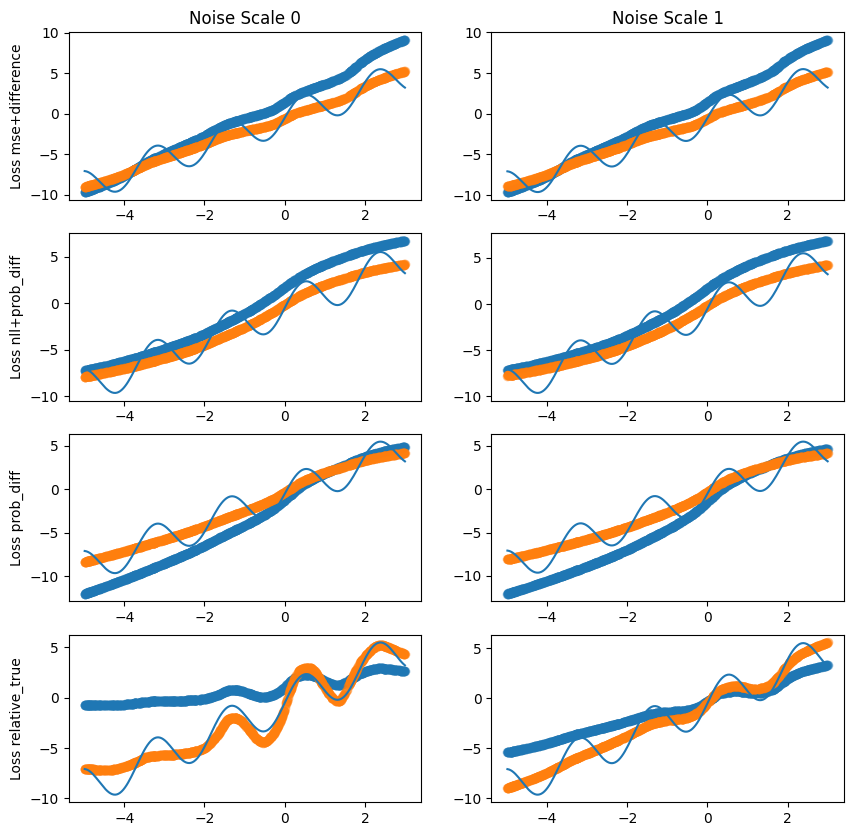

In [62]:
fig, ax = plt.subplots(len(model_names),len(noise_scales),figsize=(10,10))
func_x = torch.linspace(val_loader.dataset.data[:,0].min(),val_loader.dataset.data[:,0].max(),200)
try:
    #func_y = ((torch.einsum("ij, Bj -> Bi", val_loader.dataset.weight, func_x[:,None]) + val_loader.dataset.bias)**2 - val_loader.dataset.mean) / val_loader.dataset.std
    
    func_y =  (torch.einsum("ij, Bj -> Bi", val_loader.dataset.weight, func_x[:,None]) + val_loader.dataset.bias + 2* torch.sin(2*val_loader.dataset.weight[:,0] * func_x[:,None])- val_loader.dataset.mean) / val_loader.dataset.std

except:
    #func_y = (torch.einsum("ij, Bj -> Bi", val_loader.dataset.weight, func_x[:,None]) + val_loader.dataset.bias)**2
    func_y =  torch.einsum("ij, Bj -> Bi", val_loader.dataset.weight, func_x[:,None]) + val_loader.dataset.bias + 2* torch.sin(2*val_loader.dataset.weight[:,0] * func_x[:,None])

rel_percentage = 0.9

for i, model_name in enumerate(model_names):
    ax[i,0].set_ylabel("Loss "+model_name)
    for j, ns in enumerate(noise_scales):
        ax[0,j].set_title(f"Noise Scale {ns}")
        for s in seeds:
            pred=predictions[model_name+f"NS{ns}RP{rel_percentage}S{seed}"]
            #ax[i,j].errorbar(val_loader.dataset.data[:,0].cpu().detach().numpy(),pred[:,0].cpu().detach().numpy(),
            #                 yerr=pred[:,0].cpu().detach().numpy(), linestyle="None", label=model_name+str(seed),alpha=0.4)
            ax[i,j].scatter(val_loader.dataset.data[:,0].cpu().detach().numpy(),pred[:,0].cpu().detach().numpy(), label=model_name+str(seed),alpha=0.4)
            
        ax[i,j].plot(func_x.numpy(), func_y.numpy(), label="True Func")
        if True:
            s,b = calculate_optimal_scale_bias_analytical(pred[:,0].cpu().detach().numpy(),val_loader.dataset.clean_labels[:,0].cpu().detach().numpy())
            scaled_pred = pred[:,0].cpu().detach().numpy()*s + b
            
            print(model_name, "NS",ns, s,b, "MSE Before:", np.mean((pred[:,0].cpu().detach().numpy()-val_loader.dataset.clean_labels[:,0].cpu().detach().numpy())**2), "MSE", np.mean((scaled_pred-val_loader.dataset.clean_labels[:,0].cpu().detach().numpy())**2))
            ax[i,j].scatter(val_loader.dataset.data[:,0].cpu().detach().numpy(),scaled_pred, label=model_name+str(seed),alpha=0.4)
            
            #ax[i,j].legend()
        
        

In [ ]:
plt.scatter(val_dataset.data[:,0].cpu().detach().numpy(),val_dataset.clean_labels[:,0].cpu().detach().numpy(), label=model_name+str(seed),alpha=0.4)
plt.scatter(train_loader.dataset.data[:,0].cpu().detach().numpy(),train_loader.dataset.labels[:,0].cpu().detach().numpy(), label=model_name+str(seed),alpha=0.4)

In [176]:
(torch.einsum("ij, Bj -> Bi", val_loader.dataset.weight, func_x[:,None]) + val_loader.dataset.bias).shape

torch.Size([200, 1])

In [14]:
pred=predictions[model_name+f"NS{ns}RP{rel_percentage}S{seed}"]
print(pearson_corr(pred.cpu(), val_dataset.clean_labels))
print(pearson_corr(pred.cpu()[:,:1], val_dataset.clean_labels[:,:1]))
print(stats.pearsonr(pred.cpu().detach().numpy()[:,0], val_dataset.clean_labels[:,0].cpu().detach().numpy())[0])

tensor(-0.8472, grad_fn=<MulBackward0>)
tensor(-0.9199, grad_fn=<MulBackward0>)
0.9199277563631747


106387358923716524807713475752456393740167855629859291136

mse PearsonRResult(statistic=0.9991539680322434, pvalue=0.0) 0.0022988105
relative PearsonRResult(statistic=0.9366455815052602, pvalue=0.0) 1.9037783
nll PearsonRResult(statistic=0.9976012665769344, pvalue=0.0) 0.0061152037
relative+mse PearsonRResult(statistic=0.9933288842655449, pvalue=0.0) 0.013750616
relative_fixed PearsonRResult(statistic=0.9405428304978637, pvalue=0.0) 6.3978825


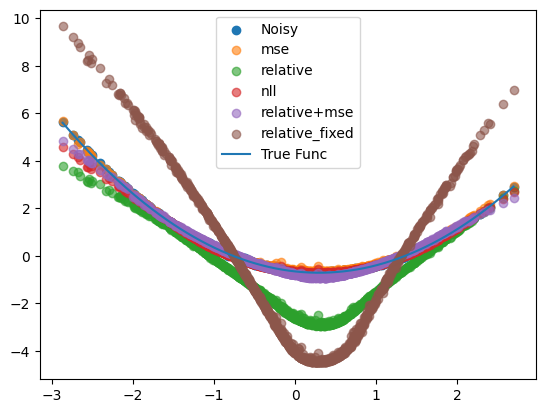

In [134]:
#pred = model(dataset.data.to("cuda"))
plt.scatter(val_dataset.data[:,0].cpu().detach().numpy(),val_dataset.labels[:,0], label="Noisy")
#plt.scatter(val_dataset.data[:,0].cpu().detach().numpy(),val_dataset.clean_labels[:,0], label="Clean")
#pred_nll = models["nll"](val_dataset.data.to("cuda"))
#pred_mse = models["mse"](val_dataset.data.to("cuda"))
#pred_relative = models["relative"](val_dataset.data.to("cuda"))
#pred_relativemse = models["relative+mse"](val_dataset.data.to("cuda"))
for model_name in model_names:
    pred = models[model_name](val_dataset.data.to("cuda"))
    print(model_name, stats.pearsonr(pred.cpu().detach().numpy()[:,0], val_dataset.clean_labels[:,0].cpu().detach().numpy()),np.mean((pred.cpu().detach().numpy()[:,0]- val_dataset.clean_labels[:,0].cpu().detach().numpy())**2))
    plt.scatter(val_dataset.data[:,0].cpu().detach().numpy(),pred[:,0].cpu().detach().numpy(), label=model_name,alpha=0.6)
#plt.scatter(val_dataset.data[:,0].cpu().detach().numpy(),pred_nll[:,0].cpu().detach().numpy(), label="nll")
#plt.scatter(val_dataset.data[:,0].cpu().detach().numpy(),pred_mse[:,0].cpu().detach().numpy(), label="mse")
#plt.scatter(val_dataset.data[:,0].cpu().detach().numpy(),pred_relative[:,0].cpu().detach().numpy(), label="relative")
func_x = torch.linspace(val_dataset.data[:,0].min(),val_dataset.data[:,0].max(),200)

func_y = ((torch.einsum("ij, Bj -> Bi", val_dataset.weight, func_x[:,None]) + val_dataset.bias)**2 - val_dataset.mean) / val_dataset.std
plt.plot(func_x.numpy(), func_y.numpy(), label="True Func")
#plt.scatter(val_dataset.data[:,0].cpu().detach().numpy(),pred_relativemse[:,0].cpu().detach().numpy(), label="relative+mse")
plt.legend()
plt.show()

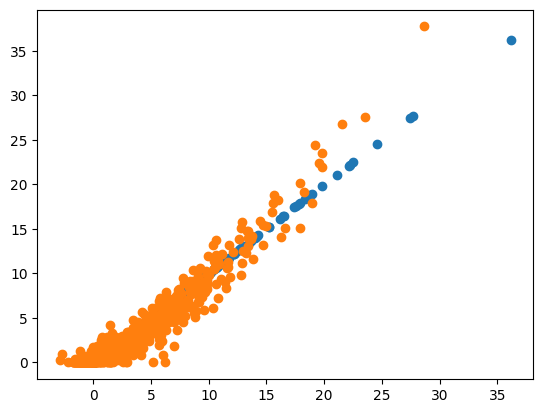

In [34]:
plt.scatter(val_dataset.clean_labels[:,0],val_dataset.clean_labels[:,0], label="Noisy")
plt.scatter(pred.cpu().detach().numpy()[:,0],dataset.clean_labels[:,0], label="Clean")